## Setup

In [46]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
register_matplotlib_converters()

In [47]:
path = 'datasets/raw'
data = pd.read_parquet(f"{path}/input_dataset-2.parquet").reset_index()
predict_inputs = pd.read_parquet(f"{path}/prediction_input.parquet").reset_index()
data["timepoints"] = data["timepoints"].astype(np.int64)
predict_inputs["timepoints"] = predict_inputs["timepoints"].astype(np.int64)

## Models

First, define a linear normalizer. Since our models had issues learning the long term linear trend of the dataset, we instead normalize it with a linear function.

In [48]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

class LinearNormalizer():
    def __init__(self,data):
        self.df = data
        nan_idx = ~np.isnan(data.iloc[:,1].values)
        X = data.iloc[:,0].values
        Y = data.iloc[:,9:15].values
        X = X[nan_idx].reshape(-1,1)
        Y = Y[nan_idx, :]
        regr = linear_model.LinearRegression()
        self.pipeline = Pipeline([("preprocess", StandardScaler()), ('poly', PolynomialFeatures(degree=1)), ("model", regr)])
        self.pipeline.fit(X, Y)

    def transform(self, X, Y):
        return Y - self.pipeline.predict(X)
    
    def inverse_transform(self, X, Y):
        return Y + self.pipeline.predict(X)


Then define main LSTM model

In [49]:
import torch #pytorch
import torch.nn as nn

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, fully_connected_size):
        super(LSTM1, self).__init__()
        self.num_layers = num_layers #number of layers
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, fully_connected_size) #fully connected 1
        self.fc = nn.Linear(fully_connected_size, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #internal state

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = output.reshape(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

## Preprocessing of data

In [50]:
# One hot encoding of 'mode' and split values in X and Y
mode_one_hot = pd.get_dummies(data["mode"])
X = np.hstack([data.iloc[:,1:7].values, mode_one_hot.values])
Y_true = data.iloc[:,9:15].values

# Remove nans
nan_idx = ~np.isnan(X).any(axis=1)
X = X[nan_idx, :]
Y_true = Y_true[nan_idx, :]
N = X.shape[0]

In [51]:
# Normalize data with Linear Normalizer
linear_normalizer = LinearNormalizer(data)
X_time = data.iloc[:,0].values[nan_idx,None]
Y_normalized = linear_normalizer.transform(X_time, Y_true)

In [52]:
# Scale data to 0 mean unit variance
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(Y_normalized)

X = x_scaler.transform(X)
Y = y_scaler.transform(Y_normalized)

In [53]:
# Split data in training and test
train_split_fraction = 0.8

X_train = X[:int(N*train_split_fraction)]
Y_train = Y[:int(N*train_split_fraction)]

X_val = X[int(N*train_split_fraction):]
Y_val = Y[int(N*train_split_fraction):]

In [54]:
seq_length = 100
X = X_train[:seq_length*(N//seq_length)]
Y = Y_train[:seq_length*(N//seq_length)]

# Reshape into (num_batches, seq_length, input_size)
X_tensor = torch.from_numpy(X).reshape(-1,seq_length,X.shape[1]).float()
Y_tensor = torch.from_numpy(Y).float()

## Training

Define training variables

In [55]:
num_epochs = 10 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 8 #number of features
hidden_size = 12 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 6 #number of output classes 

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_tensor.shape[1]) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression

Main training loop, using LBFGS as optimizer

In [56]:
optimizer = torch.optim.LBFGS(lstm1.parameters(), lr=0.08)
for epoch in range(num_epochs):
    def closure():
        optimizer.zero_grad()
        out = lstm1(X_tensor)
        loss = criterion(out, Y_tensor)
        loss.backward()
        print(f'Loss {loss.detach().item()}')
        return loss

    optimizer.step(closure) #improve from loss, i.e backprop
    with torch.no_grad():
        out = lstm1(X_tensor)
        loss = criterion(out, Y_tensor)
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

torch.save(lstm1.state_dict(), "model.pth")

Loss 0.3341100215911865
Loss 0.3303413689136505
Loss 0.2831089496612549
Loss 0.22998754680156708
Loss 0.1776440292596817
Loss 0.13733425736427307
Loss 0.11120086908340454
Loss 0.09425605833530426
Loss 0.082547627389431
Loss 0.07410931587219238
Loss 0.06776995211839676
Loss 0.06285464018583298
Loss 0.0589635968208313
Loss 0.055906299501657486
Loss 0.053518109023571014
Loss 0.05158577114343643
Loss 0.0499798059463501
Loss 0.04862773045897484
Loss 0.047474537044763565
Loss 0.04647792503237724
Epoch: 0, loss: 0.04561
Loss 0.04560632258653641
Loss 0.04483511671423912
Loss 0.04414141923189163
Loss 0.04351343214511871
Loss 0.04294655844569206
Loss 0.04243902862071991
Loss 0.041983962059020996
Loss 0.04156913235783577
Loss 0.04118827357888222
Loss 0.04083570837974548
Loss 0.04048758000135422
Loss 0.04011841490864754
Loss 0.03971843048930168
Loss 0.03930262476205826
Loss 0.03887346014380455
Loss 0.03845973312854767
Loss 0.0380464605987072
Loss 0.037401217967271805
Loss 0.03638894110918045
Loss 

## Plotting results and calculation of RMSE

Model loaded
0.023893328423423624 0.15457466941068845


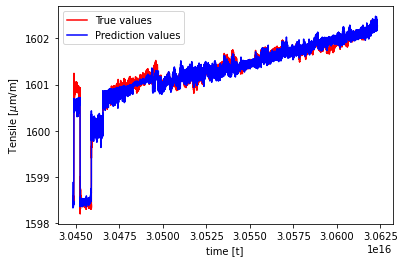

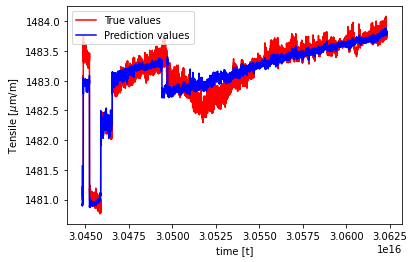

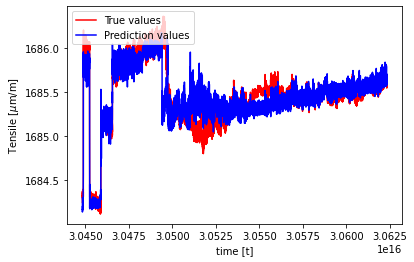

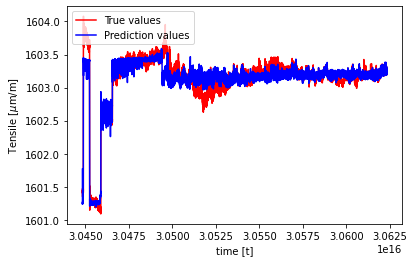

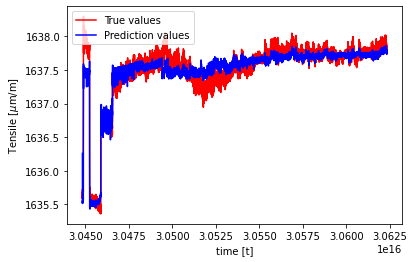

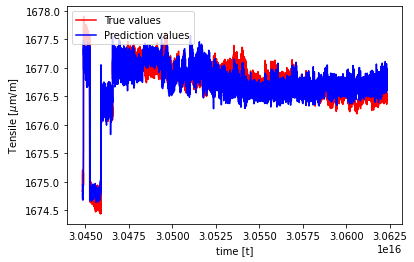

5.0673530222467695 2.251078191055737


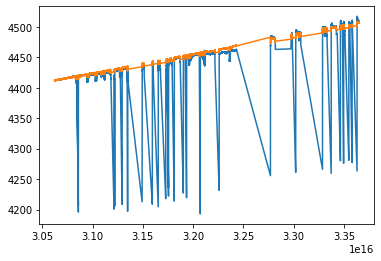

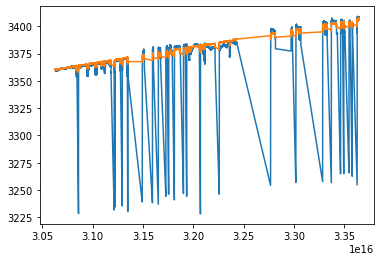

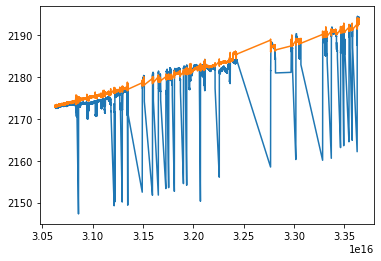

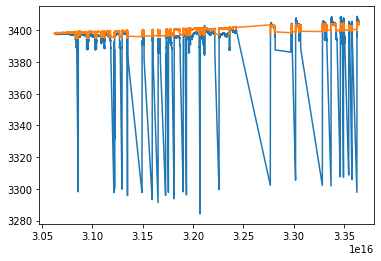

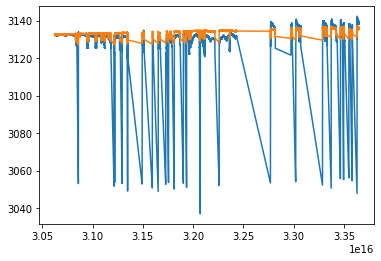

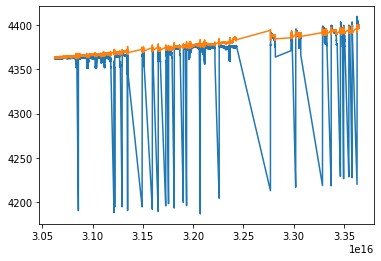

In [57]:
with torch.no_grad():
    lstm1.load_state_dict(torch.load("model.pth"))
    print("Model loaded")

    # Predicting test data and scaling back
    X_tensor = torch.from_numpy(X_train).reshape(1,-1,X_train.shape[1]).float()
    preds = lstm1(X_tensor).detach().numpy()
    preds = y_scaler.inverse_transform(preds)
    preds = linear_normalizer.inverse_transform(X_time[:int(N*train_split_fraction)], preds)

    # Calculate RMSE for train set
    err = mean_squared_error(Y_true[:int(N*train_split_fraction)], preds)
    print(err, np.sqrt(err))

    # Plotting predictions against training data
    for i in range(6):
        plt.plot(data["timepoints"][nan_idx][:int(N*train_split_fraction)], Y_true[:int(N*train_split_fraction)][:,i], '-r', label='True values')
        plt.plot(data["timepoints"][nan_idx][:int(N*train_split_fraction)], preds[:,i], '-b', label='Prediction values')
        plt.xlabel("time [t]")
        plt.ylabel(r"Tensile [$\mu$m/m]")
        plt.legend(loc="upper left")
        plt.savefig(f"tensile{i}-pred-vs-real.png")
        plt.show()

    # Predicting train data and scaling back
    X_val_tensor = torch.from_numpy(X_val).reshape(1,-1,X_val.shape[1]).float()
    preds = lstm1(X_val_tensor).detach().numpy()
    preds = y_scaler.inverse_transform(preds)
    preds = linear_normalizer.inverse_transform(X_time[int(N*train_split_fraction):], preds)

    # Calculate RMSE test set
    err = mean_squared_error(Y_true[int(N*train_split_fraction):], preds)
    print(err, np.sqrt(err))

    # Plotting predictions against test data
    for i in range(6):
        plt.plot(data["timepoints"][nan_idx][int(N*train_split_fraction):], y_scaler.inverse_transform(Y_true[int(N*train_split_fraction):])[:,i])
        plt.plot(data["timepoints"][nan_idx][int(N*train_split_fraction):], y_scaler.inverse_transform(preds)[:,i])
        plt.show()

Make csv for delivery

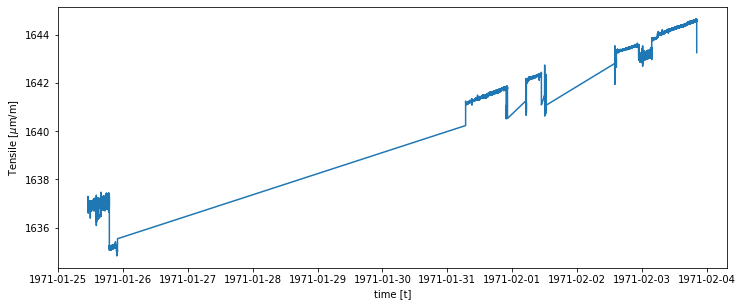

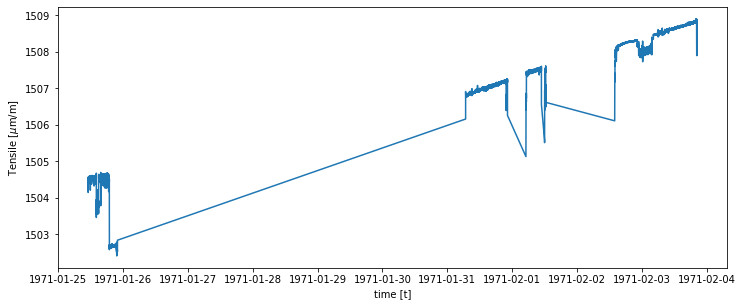

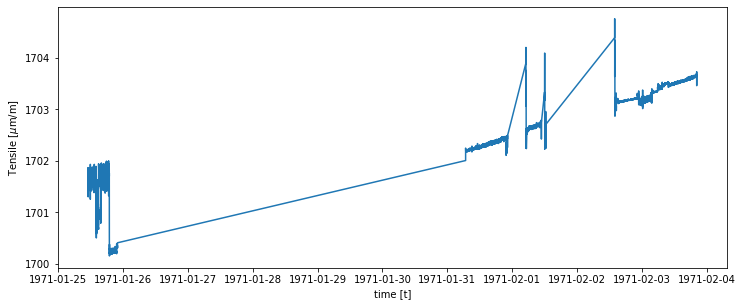

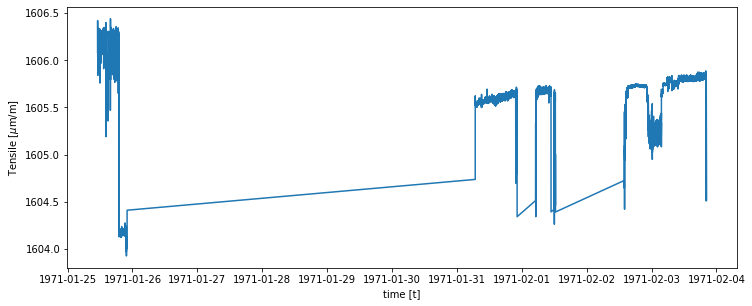

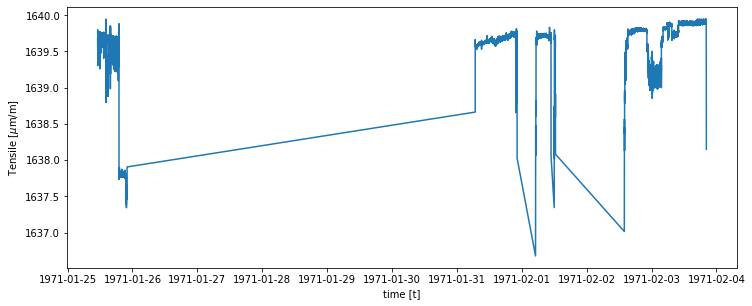

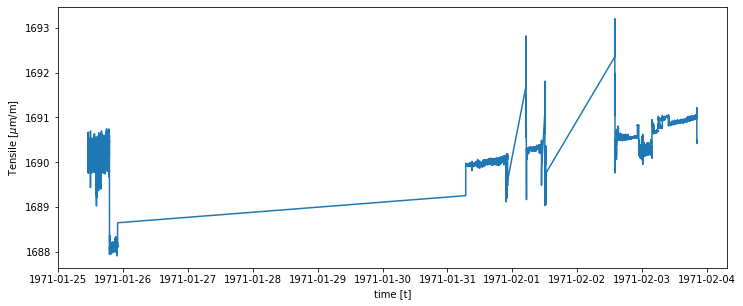

In [58]:
with torch.no_grad():
    predict_inputs = pd.read_parquet("datasets/raw/prediction_input.parquet").reset_index()
    df = pd.DataFrame({"timepoints": predict_inputs["timepoints"]})
    
    mode = pd.get_dummies(predict_inputs["mode"])
    predict_inputs["timepoints"] = predict_inputs["timepoints"].astype(np.int64)
    X_test = np.hstack([predict_inputs.iloc[:,1:7].values, mode.values])
    X_test = x_scaler.transform(X_test)
    X_test_tensor = torch.from_numpy(X_test).reshape(1,X_test.shape[0],X_test.shape[1]).float()

    X_test_time = predict_inputs.iloc[:,0].values[:,None]

    preds = lstm1(X_test_tensor).detach().numpy()
    preds = y_scaler.inverse_transform(preds)
    preds = linear_normalizer.inverse_transform(X_test_time, preds)

    
    for i in range(6):
            plt.figure(figsize=[12.0, 4.8])
            plt.plot(df["timepoints"], preds[:,i])
            plt.xlabel("time [t]")
            plt.ylabel(r"Tensile [$\mu$m/m]")
            plt.savefig(f"tensile{i}-pred.png")
            plt.show()

    for i in range(6):
        df[f"Bolt_{i+1}_Tensile"] = preds[:,i]

    df.to_csv("predict_result.csv", index=False)
